# Simple Multilayer Perceptron replication of on Black Scholes model

References:

[Professor Johannes Ruf literature review](https://arxiv.org/pdf/1911.05620.pdf)

[Robert Culkin, Sanjiv R. Das, Machine Learning in Finance: The Case of Deep Learning for Option Pricing (2017)](https://www.semanticscholar.org/paper/Machine-Learning-in-Finance-%3A-The-Case-of-Deep-for-Culkin/fffa2cec0b796707c975067654851e878a00a469).  

[Pricing options and computing implied volatilities
using neural networks
Shuaiqiang Liu](https://arxiv.org/pdf/1901.08943.pdf).

## Project Overview
### Background
**The Black Scholes model** is used to price put and call options by estimating the variation over time said financial instruments. The model is based on the assumption that the markets are highly efficient (i.e., Efficient Market Hypothesis), which suggests that stock prices are uncorrelated to one another across time. As a result, Geometric Brownian Motion (GBM) also has been assumed. However, the assumption isoften violated in practice, leading to numerous variations of the Black-Scholes model. 

The **Black-Scholes formula for European call and put options** are:

$$C(S_0,t)=S_0N(d_1)-Ke^{-r(T-t)}N(d_2)$$
$$P(S_0,t)=Ke^{-r(T-t)}N(-d_2)-S_0N(-d_1)$$
where
- $S_0$: Stock Price
- $C(S_0,t)$: Price of the Call Option
- $K$: Exercise Price
- $(T-t)$: Time to Maturity, where T is Exercise Date
- $\sigma$: Underlying Volatility (a standard deviation of log returns) (30,60,252 days returns,etc)
- $r$: Risk-free Interest Rate (i.e., T-bill Rate)

The $d_i$ variables are defined as:
$$d_1=\frac{\ln\frac{S_0}{K}+(r+\frac{\sigma^2}{2})(T-t)}{\sigma\sqrt{T-t}}$$
$$d_2=d_1-\sigma\sqrt{T-t}=\frac{\ln\frac{S_0}{K}+(r-\frac{\sigma^2}{2})(T-t)}{\sigma\sqrt{T-t}}$$

Finally, $N(x)$ is cumulative distribution function for the standard normal distribution.



### Project Objectives
In this project, we aim to do the following:
1) Recreate Culkin and Das' work\
2) See whether fitted simulated model performs well on actual data \
3) Observe if the model can perform better based on different datasets

In [1]:

from numpy.random import seed
seed(1)
import tensorflow
import numpy as np
tensorflow.random.set_seed(2)
import pandas as pd
import altair as alt
import tensorflow as tf
call = pd.read_csv('Data/SimBS.csv')
call

,Unnamed: 0,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,0,206.484182,194.386150,1.093151,0.005674,0.862692,0.058898,79.434285
1,1,79.581809,73.926431,0.843836,0.020428,0.759562,0.080634,24.975516
2,2,130.957110,154.101232,1.326027,0.019181,0.606436,0.042031,28.927743
3,3,53.020511,58.598175,0.791781,0.028475,0.572696,0.036566,8.573626
4,4,455.190704,529.570396,0.501370,0.009074,0.090578,0.044426,0.210253
...,...,...,...,...,...,...,...,...
299995,299995,350.089693,297.253216,2.290411,0.024958,0.798014,0.065783,173.232381
299996,299996,298.185427,349.183746,1.232877,0.025116,0.258656,0.098986,25.075951
299997,299997,75.461971,94.875668,2.473973,0.017064,0.765170,0.015199,28.150892
299998,299998,498.375137,360.035145,2.260274,0.025877,0.119936,0.029400,134.079063


We recreate the dataset with parameter settings below.
#### 1. Culkin and Das (2017)

To train a neural network to learn the call option pricing equation, Culkin and Das (2017) simulated a range of call option prices with ranges of different parameters:

Note that the relation between predictors are ignored. (i.e; each parameters are created randomly from it's own distribution since our hypothesis is to observe how well neural network can learn black scholes pricing.)

| Parameter              |   Range           |
|:-----------------------|:------------------|
| Stock Price $(S)$      | \\$10 — \\$50     |
| Strike Price $(K)$     |  \\$7 — \\$650    |
| Maturity $(T-t)$       | 1 day to 3 years  |
| Dividend Rate $(q)$    | 0\% — 3\%         |
| Risk Free Rate $(r)$   | 1\% — 3\%         |
| Volatility $(\sigma)$  | 5\% — 90\%        |
| Call Price $(C)$       |  \\$0 — \\$328    |

In total, the dataset contains 300,000 observations.

In [2]:
call['moneyness'] = call['Stock Price']/call['Strike Price']
call = call.drop(['Unnamed: 0'], axis= 1)
call.head()


,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price,moneyness
0,206.484182,194.386150,1.093151,0.005674,0.862692,0.058898,79.434285,1.062237
1,79.581809,73.926431,0.843836,0.020428,0.759562,0.080634,24.975516,1.076500
2,130.957110,154.101232,1.326027,0.019181,0.606436,0.042031,28.927743,0.849812
3,53.020511,58.598175,0.791781,0.028475,0.572696,0.036566,8.573626,0.904815
4,455.190704,529.570396,0.501370,0.009074,0.090578,0.044426,0.210253,0.859547


In [3]:
min(call['Call Price']!=0)

False

In [4]:
call['Indicator'] =0
call['Indicator'][call['moneyness']>1.] = 1
call['Indicator'][call['moneyness']<=1] = 0

<ipython-input-4-393505ce4e4f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call['Indicator'][call['moneyness']>1.] = 1
<ipython-input-4-393505ce4e4f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call['Indicator'][call['moneyness']<=1] = 0


In [5]:
from scipy.stats import norm
def get_BS(S,K,T,r,sigma, type='call'):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
    d2 = (np.log(S/K) + (r - 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
    if type == 'call':
            val = (S*norm.cdf(d1, 0, 1)-K*np.exp(-r*T)*norm.cdf(d2, 0, 1))
    elif type == 'put':
            val = (K*np.exp(-_r*T)*norm.cdf(-d2, 0, 1)-S *norm.cdf(-d1, 0, 1))
    return val

In [6]:
get_BS(206.484182,194.386150,1.093151,0.058898,0.862692)

80.35484648276434

### Unlike the paper, besides S,K,T,r,$\sigma$ as predictors we will also use moneyness.


In [7]:
X = call[['Stock Price','Strike Price','Maturity','Dividends','Risk-free','Volatility','moneyness','Indicator']].values
y = call['Call Price'].values
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.30,shuffle = True)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full,test_size=0.25
                                                      ,shuffle = True)
X_train.shape[1:]



(8,)

# Optimized Parameters via Random Search Optimization
| Parameter              |   Value           |
|:-----------------------|:------------------|
| Number of layers       |        6          |
| Number of Neurons      |      430          |          
| Adam learn rate        | 3e-5              |
| Dropout rate           | 0.0               |


### Normalization is done inside the model

# MLP architecture definition

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU, BatchNormalization
import keras
nodes = 120
def build_model(n_hidden=6, n_neurons=430, learning_rate=3e-5, input_shape=(8,),dropout = 0.0):
    model = Sequential()
    model.add(keras.layers.InputLayer(input_shape = input_shape))
    model.add(BatchNormalization())
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation='relu'))
        model.add(Dropout(dropout))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(lr = learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [39]:
import keras
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_model)
history = keras_reg.fit(X_train, y_train, batch_size = 1064,epochs=50,validation_data=(X_valid, y_valid),verbose = 1)

Epoch 1/50
149/149 [==============================] - 1s 8ms/step - loss: 5656.4663 - val_loss: 1769.0934
Epoch 2/50
149/149 [==============================] - 1s 6ms/step - loss: 759.5507 - val_loss: 378.2154
Epoch 3/50
149/149 [==============================] - 1s 6ms/step - loss: 186.8840 - val_loss: 153.1181
Epoch 4/50
149/149 [==============================] - 1s 6ms/step - loss: 111.2036 - val_loss: 86.6800
Epoch 5/50
149/149 [==============================] - 1s 6ms/step - loss: 63.9145 - val_loss: 40.6533
Epoch 6/50
149/149 [==============================] - 1s 6ms/step - loss: 36.2260 - val_loss: 29.4732
Epoch 7/50
149/149 [==============================] - 1s 6ms/step - loss: 24.2841 - val_loss: 17.7720
Epoch 8/50
149/149 [==============================] - 1s 6ms/step - loss: 23.7195 - val_loss: 19.7690
Epoch 9/50
149/149 [==============================] - 1s 6ms/step - loss: 18.5108 - val_loss: 14.9424
Epoch 10/50
149/149 [==============================] - 1s 6ms/step - loss

# Epoch vs error convergence

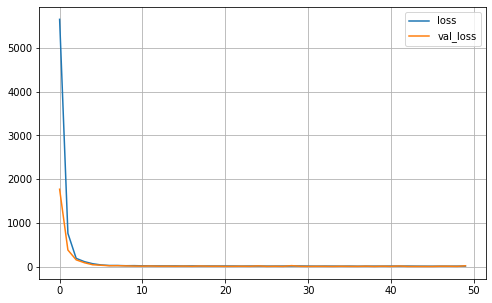

In [40]:
pd.DataFrame(history.history).plot(figsize = (8,5))
import matplotlib.pyplot as plt
plt.grid(True)
plt.show()


# R squared score and MSE on test dataset

In [41]:

predict = keras_reg.predict(X_test)
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score
print(r2_score(y_test, predict),mean_squared_error(y_test, predict))

0.9940271672516962 17.73388859722245


# For regression of error terms, we use L1 distance

In [28]:
np.seterr(divide='ignore', invalid='ignore')


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [42]:
difference = 0
difference =(predict.ravel()- y_test)
df = pd.DataFrame(data=X_test,columns = ['Stock Price','Strike Price','Maturity','Dividends','Risk-free','Volatility','moneyness','Indicator']) 
df['Pred Price'] =predict.ravel()
df['True Price'] = y_test
df['Difference'] = difference
df.head()

,Stock Price,Strike Price,Maturity,Dividends,Risk-free,Volatility,moneyness,Indicator,Pred Price,True Price,Difference
0,426.285940,333.987246,0.920548,0.026345,0.089227,0.536574,1.276354,1.0,142.793396,139.624853,3.168543
1,481.383082,376.312695,1.967123,0.021674,0.010805,0.701212,1.279210,1.0,213.076385,206.616520,6.459866
2,348.804740,433.954487,1.213699,0.002301,0.058077,0.259517,0.803782,0.0,21.412912,20.216437,1.196475
3,178.921003,169.576337,2.117808,0.009519,0.056799,0.361575,1.055106,1.0,49.260422,47.688888,1.571534
4,164.674914,211.405307,0.884932,0.028375,0.018367,0.083443,0.778954,0.0,0.215701,0.001858,0.213843


# Exploratory Data Analysis

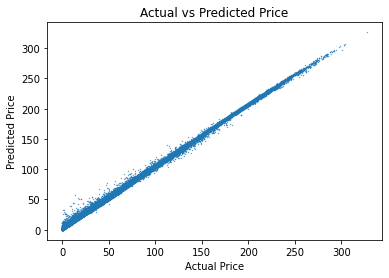

In [43]:
import matplotlib.pyplot as plt
plt.scatter(df['True Price'], df['Pred Price'], s= 0.1)
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Actual vs Predicted Price")
plt.show()

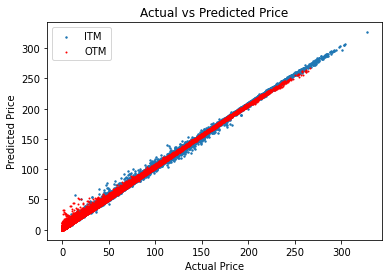

In [44]:

X_itm= X_test[X_test[:,6]>1]
X_otm =  X_test[X_test[:,6]<=1]
Y_itm = y_test[X_test[:,6]>1]
Y_otm = y_test[X_test[:,6]<=1]
plt.scatter(Y_itm,keras_reg.predict(X_itm), s=2)
plt.scatter(Y_otm, keras_reg.predict(X_otm), c='r', s=1)
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Actual vs Predicted Price")
plt.legend(['ITM', 'OTM'])
plt.show()

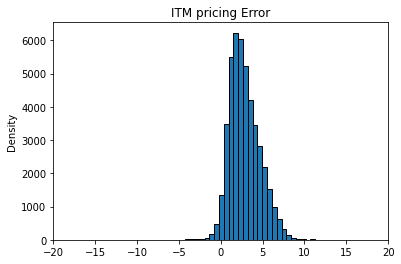

In [32]:
preds_test= keras_reg.predict(X_itm)
pricing_error_test = preds_test - Y_itm
plt.hist(pricing_error_test, bins= 80, edgecolor='black')
plt.title("ITM pricing Error")
plt.ylabel("Density")
plt.xlim((-20, 20))
plt.show()

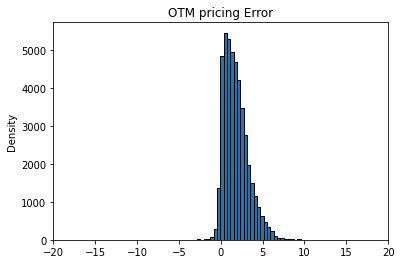

In [33]:
preds_test= keras_reg.predict(X_otm)
pricing_error_test = preds_test - Y_otm
plt.hist(pricing_error_test, bins= 80, edgecolor='black')
plt.title("OTM pricing Error")
plt.ylabel("Density")
plt.xlim((-20, 20))
plt.show()

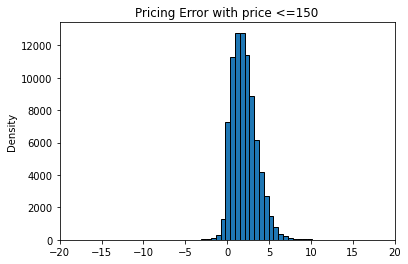

In [34]:
error1 = df[df['True Price']<=150]
error1
pricing_error_test = error1['Difference']
plt.hist(pricing_error_test, bins= 80, edgecolor='black')
plt.title("Pricing Error with price <=150")
plt.ylabel("Density")
plt.xlim((-20, 20))
plt.show()

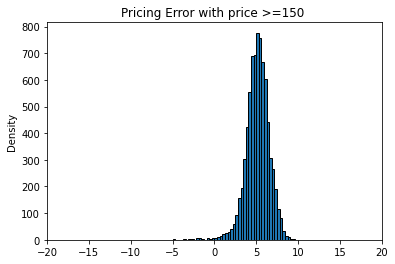

In [35]:
error3 = df[(df['True Price']>=150)]
pricing_error_test = error3['Difference']
plt.hist(pricing_error_test, bins= 50, edgecolor='black')
plt.title("Pricing Error with price >=150 ")
plt.ylabel("Density")
plt.xlim((-20, 20))
plt.show()

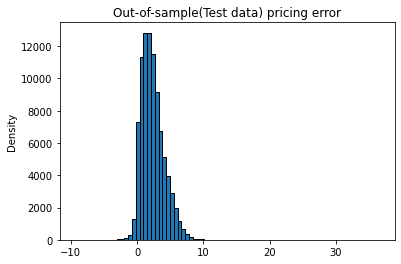

In [36]:
plt.hist(df['Difference'], bins= 80, edgecolor='black')
plt.title("Out-of-sample(Test data) pricing error")
plt.ylabel("Density")
plt.show()




### Let's do a SLR error rate vs Pred Price increase to see how much predicted price change increases error.

In [45]:
import statsmodels.api as sm
# L1 error
X = df['Pred Price']
X = sm.add_constant(X)
y = abs(df['Difference'])
reg = sm.OLS(y,X)
results = reg.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Difference   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                 6.218e+04
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        03:01:48   Log-Likelihood:            -1.7720e+05
No. Observations:               90000   AIC:                         3.544e+05
Df Residuals:                   89998   BIC:                         3.544e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8504      0.009    206.586      0.000       1.833       1.868
Pred Price     0.0258      0.000    249.358      0.000       0.026       0.026
==============================================================================
Omnibus:                    58704.267   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2483427.713
Skew:                           2.572   Prob(JB):                         0.00
Kurtosis:                      28.215   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For 1 unit increase in predicted price, the absolute difference decreases by 0.0189. Note that we use absolute difference to observe how much the price changes the overall difference

# Which predictors influence Test abs difference the most

In [46]:
X  = df[['Stock Price','Strike Price','Maturity','Dividends','Risk-free','Volatility','moneyness','Indicator']]
X = sm.add_constant(X)
y = df['Difference']
reg = sm.OLS(y,X)
results = reg.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Difference   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                 1.377e+04
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        03:01:50   Log-Likelihood:            -1.6591e+05
No. Observations:               90000   AIC:                         3.318e+05
Df Residuals:                   89991   BIC:                         3.319e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -6.5492      0.068    -96.483      0.000      -6.682      -6.416
Stock Price      0.0003      0.000      1.466      0.143      -0.000       0.001
Strike Price     0.0069      0.000     34.607      0.000       0.007       0.007
Maturity         0.7925      0.006    134.236      0.000       0.781       0.804
Dividends       -9.4117      0.589    -15.981      0.000     -10.566      -8.257
Risk-free        5.6636      0.196     28.854      0.000       5.279       6.048
Volatility       3.3251      0.021    160.441      0.000       3.284       3.366
moneyness        4.9658      0.067     73.702      0.000       4.834       5.098
Indicator        0.3767      0.019     19.480      0.000       0.339       0.415
==============================================================================
Omnibus:                    56432.020   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3931409.426
Skew:                           2.263   Prob(JB):                         0.00
Kurtosis:                      35.061   Cond. No.                     4.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

 Interesting results:   
 In the money options: the difference decreases  (In the money is better prediction,
may be more in the money data?)  
 Volatility: the difference decreases (Low volatility preferred)  
Maturity: The difference decreases insignificantly. (High maturity preferred)

# Diagnose what predictors are important (Just for personal)

Recall: $H_0$: $\beta_i$ = 0

In [23]:
X  = call[['Stock Price','Strike Price','Maturity','Dividends','Risk-free','Volatility','moneyness','Indicator']]
X = sm.add_constant(X)
y = call['Call Price']
reg = sm.OLS(y,X)
results = reg.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Call Price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                 2.224e+05
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        02:55:25   Log-Likelihood:            -1.3348e+06
No. Observations:              300000   AIC:                         2.670e+06
Df Residuals:                  299991   BIC:                         2.670e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -96.4103      0.503   -191.518      0.000     -97.397     -95.424
Stock Price      0.6305      0.002    416.891      0.000       0.628       0.633
Strike Price    -0.3847      0.001   -258.561      0.000      -0.388      -0.382
Maturity        21.2049      0.044    485.245      0.000      21.119      21.291
Dividends     -253.5676      4.369    -58.036      0.000    -262.131    -245.004
Risk-free      144.5833      1.456     99.333      0.000     141.730     147.436
Volatility      93.6088      0.154    608.622      0.000      93.307      93.910
moneyness       16.9441      0.499     33.937      0.000      15.965      17.923
Indicator       -2.8141      0.143    -19.646      0.000      -3.095      -2.533
==============================================================================
Omnibus:                    13858.964   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27638.066
Skew:                           0.338   Prob(JB):                         0.00
Kurtosis:                       4.324   Cond. No.                     4.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""